Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

###**Importing Skin Cancer Data**

**Importing all the important libraries**

In [247]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [248]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [249]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset 
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [250]:
# Count the number of images in Train and Test directory
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
#Image count in train directory
print(image_count_train)
#Image count in test directory
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2241
118


### **Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

**Create a dataset**

Define some parameters for the loader: 

In [251]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [252]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2241 files belonging to 9 classes.
Using 1793 files for training.


In [253]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2241 files belonging to 9 classes.
Using 448 files for validation.


In [254]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### **Visualize the data**

**Todo, create a code to visualize one instance of all the nine classes present in the dataset**

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


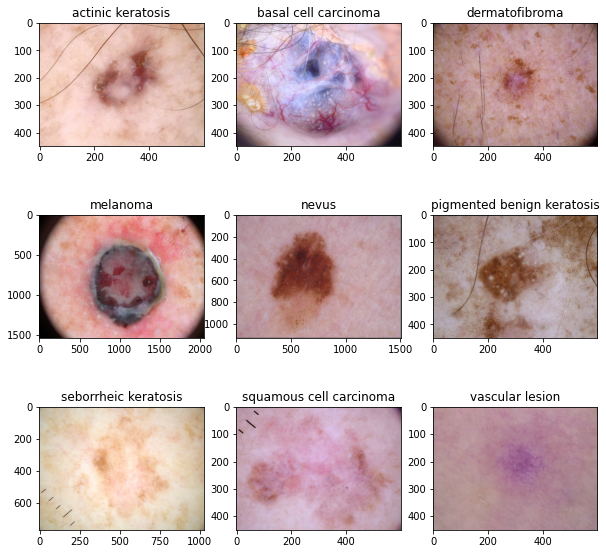

In [255]:
import matplotlib.pyplot as plt
print(class_names)
### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [256]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### **Create the model**
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [257]:
#CNN Model
#create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_14 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_42 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 41, 41, 128)     

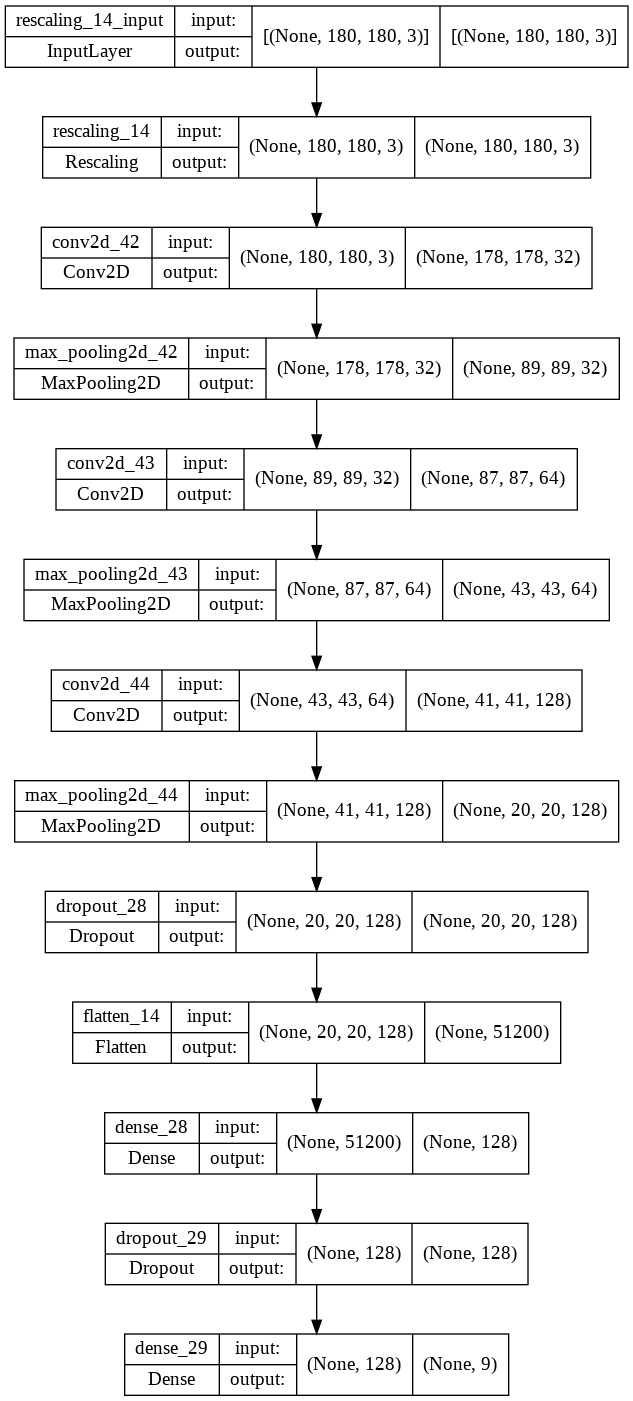

In [258]:
# vizualizing the model 
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### **Compile the model**
Choose an appropirate optimiser and loss function for model training

In [259]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [260]:
# Define checkpoint
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

In [261]:
#Define earlystop to stop training when model stop improving
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

### **Train the model**

In [262]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint,earlystop]
)

Epoch 1/20
56/57 [============================>.] - ETA: 0s - loss: 2.0842 - accuracy: 0.2266
Epoch 1: val_accuracy improved from -inf to 0.31027, saving model to model.h5
57/57 [==============================] - 16s 91ms/step - loss: 2.0803 - accuracy: 0.2276 - val_loss: 1.8908 - val_accuracy: 0.3103
Epoch 2/20
56/57 [============================>.] - ETA: 0s - loss: 1.7583 - accuracy: 0.3958
Epoch 2: val_accuracy improved from 0.31027 to 0.37723, saving model to model.h5
57/57 [==============================] - 2s 42ms/step - loss: 1.7541 - accuracy: 0.3982 - val_loss: 1.6616 - val_accuracy: 0.3772
Epoch 3/20
56/57 [============================>.] - ETA: 0s - loss: 1.5717 - accuracy: 0.4435
Epoch 3: val_accuracy improved from 0.37723 to 0.48214, saving model to model.h5
57/57 [==============================] - 2s 41ms/step - loss: 1.5682 - accuracy: 0.4445 - val_loss: 1.5840 - val_accuracy: 0.4821
Epoch 4/20
56/57 [============================>.] - ETA: 0s - loss: 1.5102 - accuracy: 

### **Visualizing training results**

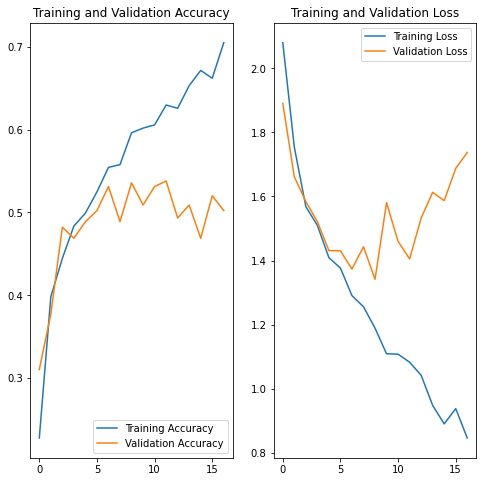

In [263]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

if len(acc) != epochs:
  epochs_range = range(earlystop.stopped_epoch + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit**

### **Write your findings here**

Findings based on above plots:
1. Training accuracy is more that 70%.
2. Training loss and Validation loss started varying after 0-5 epoch.

In [265]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

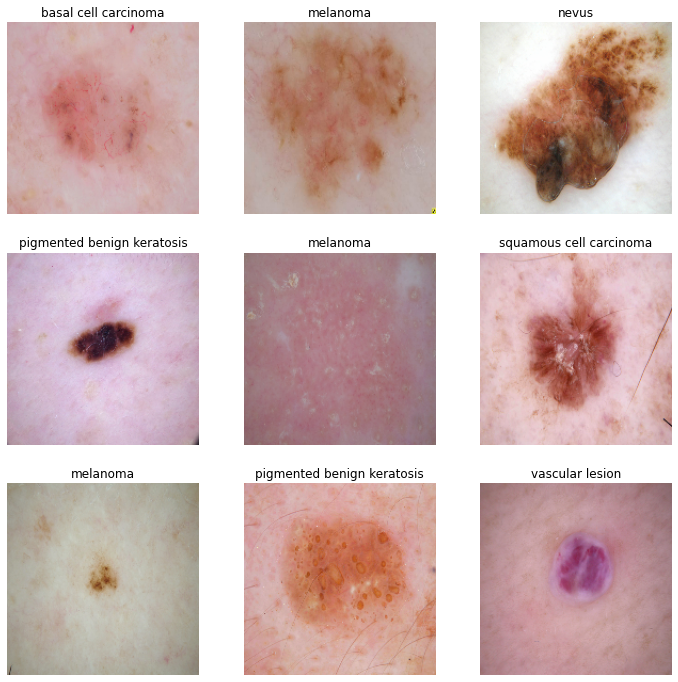

In [266]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### **Todo:**
### **Create the model, compile and train the model**

In [267]:
#CNN Model
#create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_15 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_45 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 41, 41, 128)     

### **Compiling the model**

In [268]:
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [269]:
# Define checkpoint
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

In [270]:
#Define earlystop to stop training when model stop improving
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

### **Training the model**

In [271]:
## Train Model after agumentation
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint,earlystop]
)

Epoch 1/20
56/57 [============================>.] - ETA: 0s - loss: 2.0698 - accuracy: 0.2340
Epoch 1: val_accuracy improved from -inf to 0.28125, saving model to model.h5
57/57 [==============================] - 3s 45ms/step - loss: 2.0686 - accuracy: 0.2348 - val_loss: 1.8770 - val_accuracy: 0.2812
Epoch 2/20
56/57 [============================>.] - ETA: 0s - loss: 1.8784 - accuracy: 0.3174
Epoch 2: val_accuracy did not improve from 0.28125
57/57 [==============================] - 2s 39ms/step - loss: 1.8799 - accuracy: 0.3146 - val_loss: 1.8930 - val_accuracy: 0.2768
Epoch 3/20
56/57 [============================>.] - ETA: 0s - loss: 1.8354 - accuracy: 0.3345
Epoch 3: val_accuracy improved from 0.28125 to 0.33036, saving model to model.h5
57/57 [==============================] - 2s 41ms/step - loss: 1.8354 - accuracy: 0.3324 - val_loss: 1.8166 - val_accuracy: 0.3304
Epoch 4/20
56/57 [============================>.] - ETA: 0s - loss: 1.7553 - accuracy: 0.3453
Epoch 4: val_accuracy im

### **Visualizing the results**

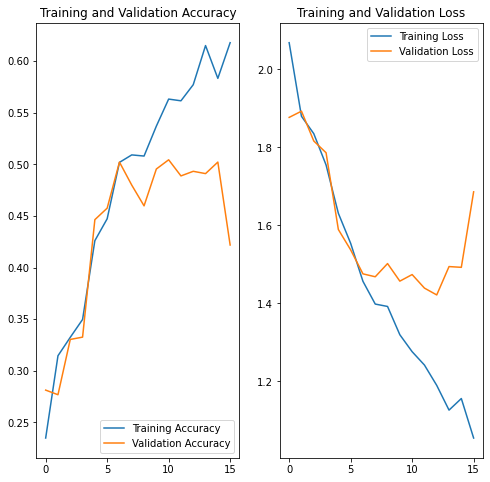

In [272]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

if len(acc) != epochs:
  epochs_range = range(earlystop.stopped_epoch + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?**

Finding on above model:
1. There is are no major change but there is improvement after augmentation in data distribution
2. We can increase more epochs to increase accuracy more.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have **class imbalance**, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [273]:
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
1,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
2,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
3,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
4,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
...,...,...
2236,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
2237,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
2238,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
2239,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion


In [274]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
1,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
2,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
3,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
4,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
...,...,...
2236,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
2237,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
2238,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
2239,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion


<BarContainer object of 9 artists>

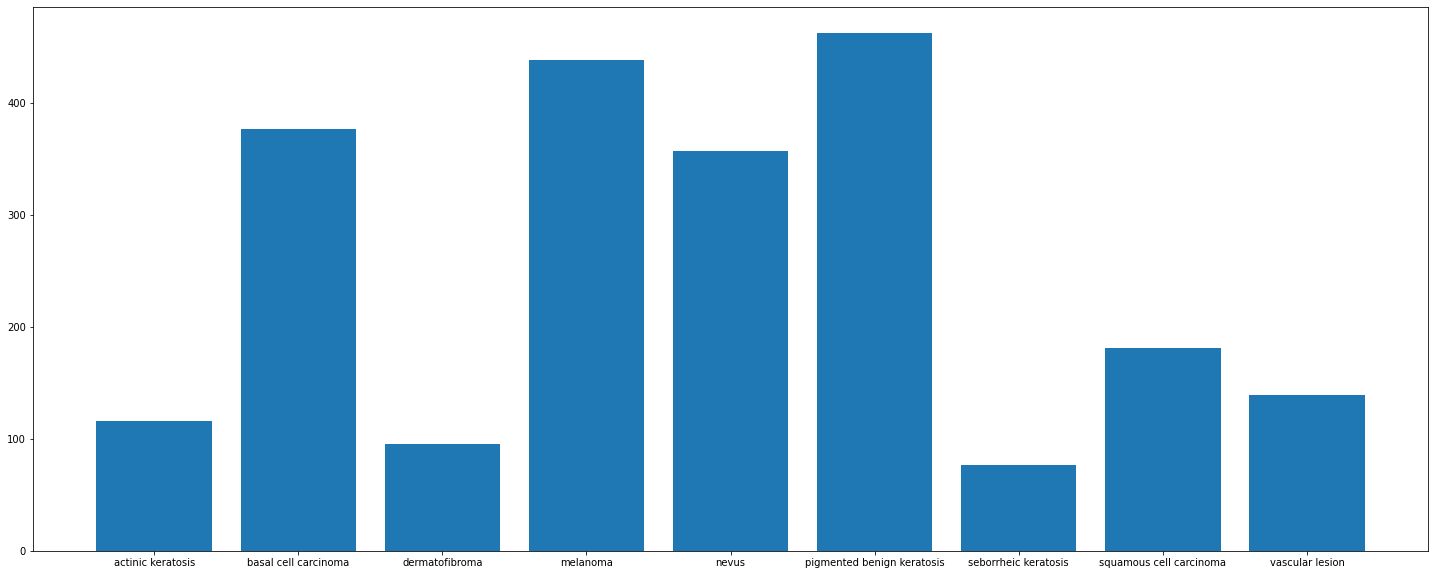

In [275]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

**Todo: Write your findings here:** 

Which class has the least number of samples?
 
 Ans : seborrheic keratosis

Which classes dominate the data in terms proportionate number of samples?

Ans : pigmented benign keratosis and melanoma 

**Todo: Rectify the class imbalance**

**Context: You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.**

In [276]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [277]:
path_to_training_dataset="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 116 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC0C1FF5F90>: 100%|██████████| 500/500 [00:21<00:00, 23.13 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC0B0540D10>: 100%|██████████| 500/500 [00:21<00:00, 23.61 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC01E7D89D0>: 100%|██████████| 500/500 [00:21<00:00, 23.59 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x7FC01F32D1D0>: 100%|██████████| 500/500 [01:32<00:00,  5.40 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7FC0BCE36810>: 100%|██████████| 500/500 [01:22<00:00,  6.03 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC01E8A9850>: 100%|██████████| 500/500 [00:20<00:00, 24.44 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FC0B0500850>: 100%|██████████| 500/500 [00:45<00:00, 11.02 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC02A4DB5D0>: 100%|██████████| 500/500 [00:18<00:00, 27.38 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC0BEC91B10>: 100%|██████████| 500/500 [00:18<00:00, 27.21 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [278]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### **Lets see the distribution of augmented data after adding new images to the original training data.**

In [279]:
for i in class_names:
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))

In [280]:
path_list

['/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0027172.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0029827.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0028854.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0028190.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0029141.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0028990.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0027668.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collabora

In [281]:
for i in class_names:
    for j in data_dir_train.glob(i+'/*.jpg'):
        lesion_list.append(i)
 
lesion_list

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [282]:
#create new directory
dataframe_dict_new = dict(zip(path_list, lesion_list))

In [283]:
#create dataframe
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [284]:
#Get labels count
new_df['Label'].value_counts()

pigmented benign keratosis    924
melanoma                      876
basal cell carcinoma          752
nevus                         714
squamous cell carcinoma       362
vascular lesion               278
actinic keratosis             232
dermatofibroma                190
seborrheic keratosis          154
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

**Todo : Train the model on the data created using Augmentor**

In [285]:
batch_size = 32
img_height = 180
img_width = 180

**Todo: Create a training dataset**

In [286]:
data_dir_train="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6741 files belonging to 9 classes.
Using 5393 files for training.


**Todo: Create a validation dataset**

In [287]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6741 files belonging to 9 classes.
Using 1348 files for validation.


**Todo: Create your model (make sure to include normalization)**

In [288]:
#CNN Model
#create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))


#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Normalization Layer
model.add(layers.BatchNormalization())

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_16 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 41, 41, 128)     

**Todo: Compile your model (Choose optimizer and loss function appropriately)**

In [289]:
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [290]:
# Define checkpoint
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

In [291]:
#Define earlystop to stop training when model stop improving
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

**Todo:  Train your model**

In [ ]:
epochs = 30
## 30 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint,earlystop]
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - ETA: 0s - loss: 1.6868 - accuracy: 0.3733
Epoch 1: val_accuracy improved from -inf to 0.45104, saving model to model.h5
169/169 [==============================] - 33s 184ms/step - loss: 1.6868 - accuracy: 0.3733 - val_loss: 1.4707 - val_accuracy: 0.4510
Epoch 2/30
169/169 [==============================] - ETA: 0s - loss: 1.4140 - accuracy: 0.4743
Epoch 2: val_accuracy improved from 0.45104 to 0.49852, saving model to model.h5
169/169 [==============================] - 31s 177ms/step - loss: 1.4140 - accuracy: 0.4743 - val_loss: 1.3941 - val_accuracy: 0.4985
Epoch 3/30
169/169 [==============================] - ETA: 0s - loss: 1.3085 - accuracy: 0.5186
Epoch 3: val_accuracy improved from 0.49852 to 0.52226, saving model to model.h5
169/169 [==============================] - 30s 175ms/step - loss: 1.3085 - accuracy: 0.5186 - val_loss: 1.3170 - val_accuracy: 0.5223
Epoch 4/30
169/169 [==============================] - ETA: 0s - loss: 1.2127 - ac

**Todo: Visualize the model results**

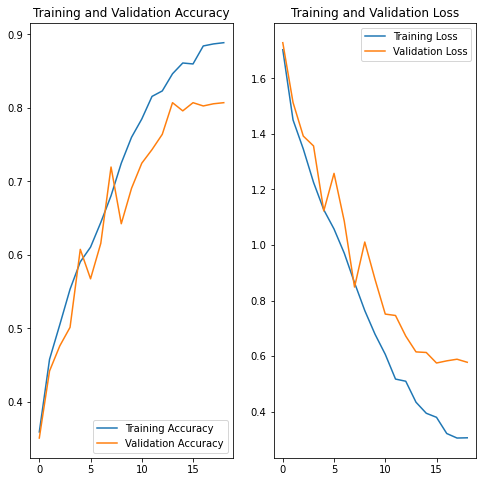

In [246]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

if len(acc) != epochs:
  epochs_range = range(earlystop.stopped_epoch + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Todo: Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?**

Above model details shows that  - 
1. Model training accuracy is improved much after agumentation and epoch increase
2. Validation accuracy also increased.
3. Train loss and validation loss also improved

Train accuracy = 0.9414

Validation accuracy = 0.8160


In [141]:
# Final Evaluate the train model 
results = model.evaluate(train_ds, batch_size = batch_size )
print("Train loss: {:.4f}".format(results[0]))
print("Train accuracy: {:.4f}".format(results[1]))
print(results)

val_results = model.evaluate(val_ds, batch_size = batch_size )
print("validation loss: {:.4f}".format(val_results[0]))
print("validation accuracy: {:.4f}".format(val_results[1]))

169/169 [==============================] - 29s 166ms/step - loss: 0.1632 - accuracy: 0.9518
Train loss: 0.1632
Train accuracy: 0.9518
[0.16321082413196564, 0.951789379119873]
43/43 [==============================] - 6s 112ms/step - loss: 0.8042 - accuracy: 0.8435
validation loss: 0.8042
validation accuracy: 0.8435


### **Model Prediction**

Actual Class basal cell carcinoma
Predictive Class pigmented benign keratosis


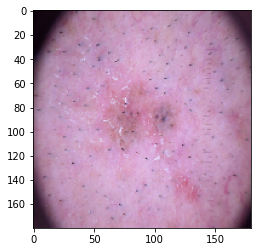

In [198]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img

Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )